In [84]:
# following tutorial from https://www.tensorflow.org/tutorials/images/classification
# trying it out on my own using car data
# import the necessary packages

import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import shutil
from shutil import copy
import PIL
import tensorflow as tf
# imported pandas for data manipulation (to see the tables and format the tables)
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
# figure out how to import the car dataset from 
# https://ai.stanford.edu/~jkrause/cars/car_dataset.html

# this shows the boundary box for where the car is located in the image
# first 4 numbers is the boundary around the car, class is omitted, then picture it's associated to
# reads the .mat information (matlab file from car_devkit)
# used this to convert file to dict: 
# https://stackoverflow.com/questions/874461/read-mat-files-in-python
import scipy.io
mat = scipy.io.loadmat('cars_test_annos.mat')
print(mat.keys())
print(mat['annotations'])
# revisiting this 4/9/2021
matData = [[row.flat[0] for row in line] for line in mat['annotations'][0]]
matColumns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
dataSetTest = pd.DataFrame(matData, columns=matColumns)
dataSetTest.head()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])
[[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
  (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
  (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array(['00003.jpg'], dtype='<U9'))
  ...
  (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array(['08039.jpg'], dtype='<U9'))
  (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array(['08040.jpg'], dtype='<U9'))
  (array([[77]], dtype=uint8), array([[73]], dtype=uint8), array([[506]], dtype=uint16), array([[380]], dtype=uint16), array(['08041.jpg'], dtype='<U9'))]

bbox_x1  bbox_y1  bbox_x2  bbox_y2      fname
0       30       52      246      147  00001.jpg
1      100       19      576      203  00002.jpg
2       51      105      968      659  00003.jpg
3       67       84      581      407  00004.jpg
4      140      151      593      339  00005.jpg

In [5]:
# this shows the boundary box for where the car is located in the image
# first 4 numbers is the boundary around the car,
# then class is using the array of class_names in cars_meta.mat,
# then the last one is the picture that is associated to that class
mat2 = scipy.io.loadmat('cars_train_annos.mat')
print(mat2.keys())
print(mat2['annotations'])
# revisiting this 4/9/2021
mat2Data = [[row.flat[0] for row in line] for line in mat2['annotations'][0]]
mat2Columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
dataSetTrain = pd.DataFrame(mat2Data, columns=mat2Columns)
dataSetTrain.head()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])
[[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
  (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
  (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))
  ...
  (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9'))
  (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9'))
  (ar

bbox_x1  bbox_y1  bbox_x2  bbox_y2  class      fname
0       39      116      569      375     14  00001.jpg
1       36      116      868      587      3  00002.jpg
2       85      109      601      381     91  00003.jpg
3      621      393     1484     1096    134  00004.jpg
4       14       36      133       99    106  00005.jpg

In [7]:
# list of different car names from the
# https://ai.stanford.edu/~jkrause/cars/car_dataset.html

mat3 = scipy.io.loadmat('cars_meta.mat')
print(mat3.keys())
print(mat3['class_names'])
# revisiting this 4/9/2021
mat3Data = [[row.flat[0] for row in line] for line in mat3['class_names'][0]]
mat3Columns = ['car_name']
dataSetCarNames = pd.DataFrame(mat3Data, columns=mat3Columns)
dataSetCarNames.head()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])
[[array(['AM General Hummer SUV 2000'], dtype='<U26')
  array(['Acura RL Sedan 2012'], dtype='<U19')
  array(['Acura TL Sedan 2012'], dtype='<U19')
  array(['Acura TL Type-S 2008'], dtype='<U20')
  array(['Acura TSX Sedan 2012'], dtype='<U20')
  array(['Acura Integra Type R 2001'], dtype='<U25')
  array(['Acura ZDX Hatchback 2012'], dtype='<U24')
  array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40')
  array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34')
  array(['Aston Martin Virage Convertible 2012'], dtype='<U36')
  array(['Aston Martin Virage Coupe 2012'], dtype='<U30')
  array(['Audi RS 4 Convertible 2008'], dtype='<U26')
  array(['Audi A5 Coupe 2012'], dtype='<U18')
  array(['Audi TTS Coupe 2012'], dtype='<U19')
  array(['Audi R8 Coupe 2012'], dtype='<U18')
  array(['Audi V8 Sedan 1994'], dtype='<U18')
  array(['Audi 100 Sedan 1994'], dtype='<U19')
  array(['Audi 100 Wagon 1994'], dtype='<U

car_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [71]:
# use https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5 to format the data in
# easily accessible format (hopefully)
# https://colab.research.google.com/github/ashiquem/vault/blob/master/python/Matlab%20Data%20Demo.ipynb
# using that information we can distribute the jpgs into appropriate folders (similar to the flower tutorial)
# will probably try to work on this tomorrow 4/7/2021
# today is 4/9/2021 going to try and get this working
# simple join of the two tables above
result = dataSetTrain.join(dataSetCarNames, on="class")
result.head()
# need to create a folder and separate the data based on fname and car_name

bbox_x1  bbox_y1  bbox_x2  bbox_y2  class      fname  \
0       39      116      569      375     14  00001.jpg   
1       36      116      868      587      3  00002.jpg   
2       85      109      601      381     91  00003.jpg   
3      621      393     1484     1096    134  00004.jpg   
4       14       36      133       99    106  00005.jpg   

                        car_name  
0             Audi R8 Coupe 2012  
1           Acura TL Type-S 2008  
2        Dodge Magnum Wagon 2008  
3     Hyundai Elantra Sedan 2007  
4  Ford Mustang Convertible 2007

In [75]:
# print("File exists: "+str(path.exists("stanfordCarDataset")))
# there's a problem with this portion
# go through the rows
# each row grab the fname that is in cars_train
# and place it in a folder called car_name within stanfordCarDataset
# if folder doesn't exist create it otherwise add it to the folder
for index, row in result.iterrows():
#    if (str(row['class']) == '85'):
#       print(str(row['class']) + ", " + str(row['car_name']) + ", " + str(row['fname']))
    tempVar = ""
    if (type(row['car_name']) is float): # deals with nan
        tempVar = str(row['car_name'])
    elif ('/' in row['car_name']): # deals with Ram C/V Cargo Van Minivan 2012 (can't create Ram C directory)
        #print(row['car_name'])
        tempVar = row['car_name']
        # just removed the C/V portion
        tempVar = tempVar.replace(' C/V', '')
    else:
        tempVar = row['car_name']
    #print(tempVar)
    
    # checks whether the folder already exists if it doesn't then it creates it
    # and puts the image in that folder
    # print("cars_train/" + row['fname'] + " : " + str(path.exists("cars_train/" + row['fname'])))
    # if (path.exists("stanfordCarDataset/" + str(tempVar)) == False):
    #  os.mkdir("stanfordCarDataset/" + str(tempVar))
    # check whether the picture was already copied
    #if (path.exists("stanfordCarDataset/" + str(tempVar) + "cars_train/" + row['fname']) == False):
     #  copy("cars_train/" + row['fname'], "stanfordCarDataset/" + str(tempVar))
# was able to make it run and create folders without any issues

In [76]:
# can finally try the tensorflow portion
import pathlib
# used the kaggle dataset because couldn't get the files up and running, will have to take a look at it again later
data_dir = pathlib.Path("carDataset")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8041


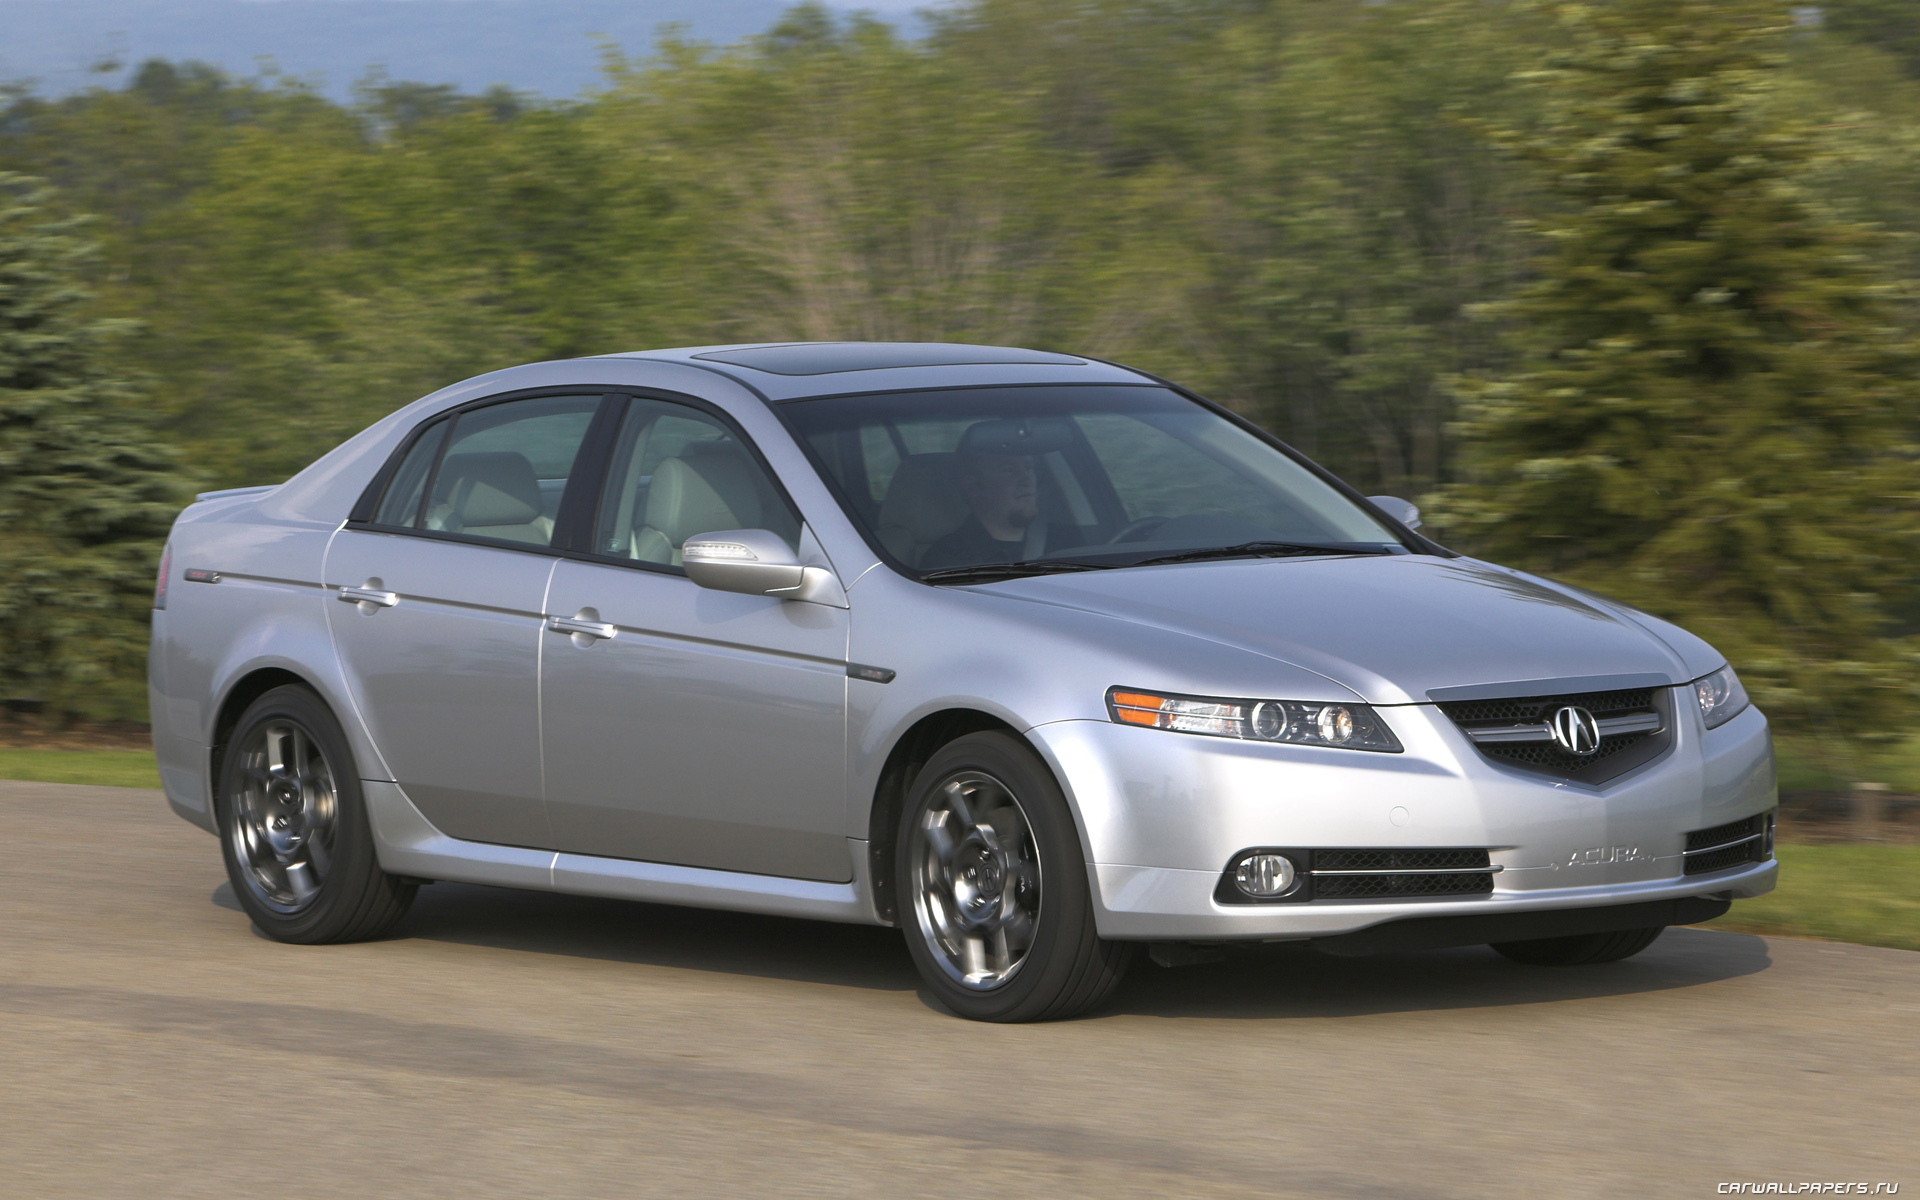

In [77]:
acuraTypeS = list(data_dir.glob('Acura TL Type-S 2008/*'))
PIL.Image.open(str(acuraTypeS[2]))

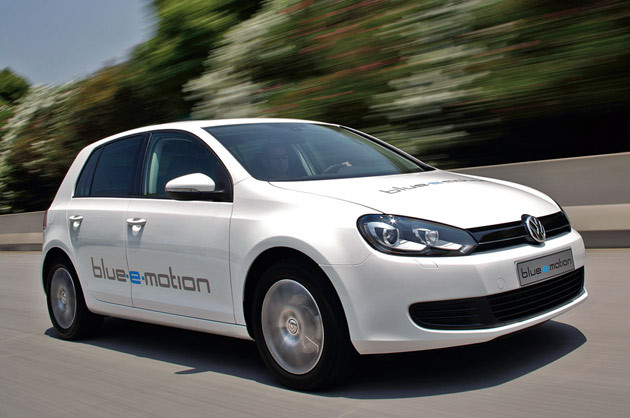

In [78]:
vwGolfHB2012 =  list(data_dir.glob('Volkswagen Golf Hatchback 2012/*'))
PIL.Image.open(str(vwGolfHB2012[2]))

In [79]:
# define some parameters of the image
# batch size is size of batches of data (default is 32)
# other parameters are listed here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

batch_size = 32
img_height = 180
img_width = 180


In [80]:
# validation split normally 80% of images for training and 20% for validation meaning validation_split set to 0.2
# this is the set used to train the model

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 8041 files belonging to 196 classes.
Using 6433 files for training.


In [81]:
# this is the set used to validated the model

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8041 files belonging to 196 classes.
Using 1608 files for validation.


In [82]:
# these attributes are listed in the datasets (directory names in alphabetical order)
class_names = train_ds.class_names
print(class_names)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

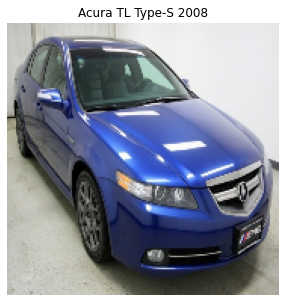

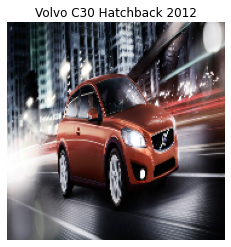

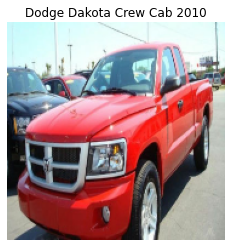

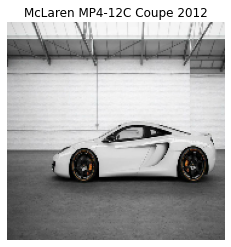

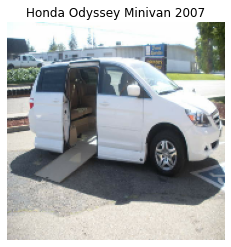

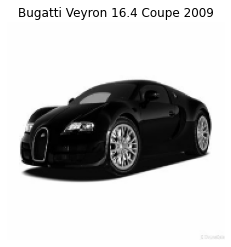

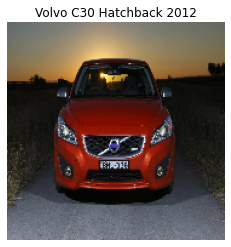

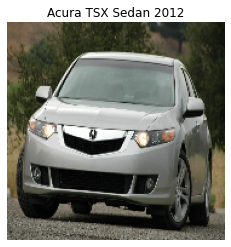

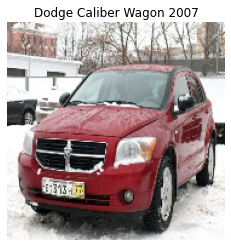

In [85]:
# obtain the 1st 9 images from the training dataset
# was running into an issue where not all the images were showing, 
# used: https://stackoverflow.com/questions/39947551/how-to-display-ndarray-images-inline-during-loop-in-ipython/39953765
# to solve that by putting a plt.show() statement at the end of each instance in the for loop

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        # show the image
        plt.imshow(images[i].numpy().astype("uint8"))
        # gets name of the flower (from directory and sets as label for image)
        plt.title(class_names[labels[i]])
        # removes axis
        plt.axis("off")
        plt.show()

In [86]:
# to see the batches of images we can print the tensor shape of each batch (we can also convert the tensors to arrays)
# image_batch is tensor of shape (32, 180, 180, 3) - 32 images of shape 180x180x3 where 3 is the color channels (RGB)
# label_batch is tensor of shape (32, ), these are corresponding labels to the 32 images

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


In [87]:
# different methods for running data
# dataset.cache() - keeps images in memory after they're loaded off disk during the first epoch. 
# ensure dataset does not become a bottleneck while training your model. If dataset is too large
# to fit into memory can also use this method to create a performant on-disk cache
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
# standardizes the values to be in [0,1] range instead of [0, 255] (RGB)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [89]:
# apply the rescaling layer to the dataset by calling map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))



0.0 1.0


In [95]:
# then we create the model
# model has 3 convolution blocks with max pool layer in each of them. 
# fully connected layer with 128 units on top of it that is activated by a relu
# activation function, (standard approach of creating model)

num_classes = 196

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [96]:
# choose an optimizer and loss function to view training and validation
# accuracy for each training epoch, pass the metrics argument
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [98]:
# this is to train the model

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
202/202 [==============================] - 66s 325ms/step - loss: 5.2736 - accuracy: 0.0047 - val_loss: 5.2003 - val_accuracy: 0.0100
Epoch 2/20
202/202 [==============================] - 60s 297ms/step - loss: 5.1449 - accuracy: 0.0139 - val_loss: 5.1699 - val_accuracy: 0.0168
Epoch 3/20
202/202 [==============================] - 61s 302ms/step - loss: 4.9847 - accuracy: 0.0312 - val_loss: 5.1782 - val_accuracy: 0.0174
Epoch 4/20
202/202 [==============================] - 63s 310ms/step - loss: 4.3738 - accuracy: 0.1105 - val_loss: 5.4489 - val_accuracy: 0.0274
Epoch 5/20
202/202 [==============================] - 64s 319ms/step - loss: 2.6841 - accuracy: 0.3965 - val_loss: 7.2528 - val_accuracy: 0.0336
Epoch 6/20
202/202 [==============================] - 67s 330ms/step - loss: 0.8174 - accuracy: 0.8050 - val_loss: 9.8455 - val_accuracy: 0.0267
Epoch 7/20
202/202 [==============================] - 65s 320ms/step - loss: 0.1692 - accuracy: 0.9661 - val_loss: 12.3809 - val_a

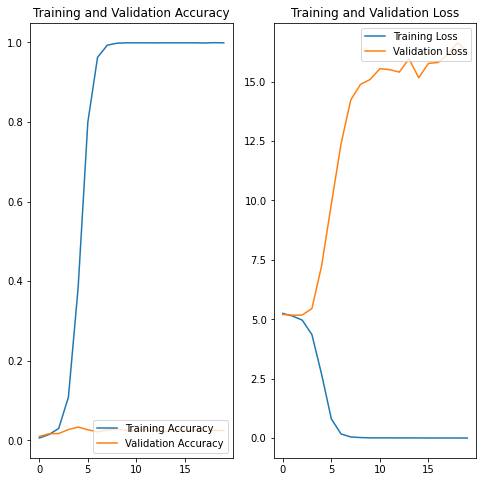

In [99]:
# now we visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
# generate additional training data from existing examples (random transformations)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

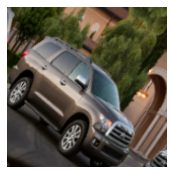

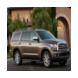

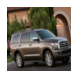

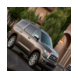

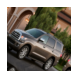

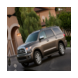

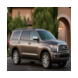

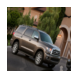

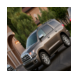

In [101]:
# shows how some of the images look like after transformations
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

In [102]:
# can reduce overfitting by regularization (randomly drops out a number
# of output units from the layer during the training process)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [103]:
# choose an optimizer and loss function to view training and validation
# accuracy for each training epoch, pass the metrics argument
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [107]:
# this is to train the model
# can take some time

epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/50
202/202 [==============================] - 69s 340ms/step - loss: 2.9760 - accuracy: 0.3067 - val_loss: 6.4045 - val_accuracy: 0.0435
Epoch 2/50
202/202 [==============================] - 69s 340ms/step - loss: 2.8590 - accuracy: 0.3355 - val_loss: 6.5307 - val_accuracy: 0.0498
Epoch 3/50
202/202 [==============================] - 68s 339ms/step - loss: 2.7860 - accuracy: 0.3414 - val_loss: 7.0449 - val_accuracy: 0.0485
Epoch 4/50
202/202 [==============================] - 70s 347ms/step - loss: 2.7002 - accuracy: 0.3582 - val_loss: 6.7636 - val_accuracy: 0.0572
Epoch 5/50
202/202 [==============================] - 69s 340ms/step - loss: 2.6391 - accuracy: 0.3695 - val_loss: 6.6085 - val_accuracy: 0.0591
Epoch 6/50
202/202 [==============================] - 69s 340ms/step - loss: 2.6215 - accuracy: 0.3757 - val_loss: 6.7504 - val_accuracy: 0.0609
Epoch 7/50
202/202 [==============================] - 69s 340ms/step - loss: 2.5051 - accuracy: 0.3917 - val_loss: 7.2570 - val_ac

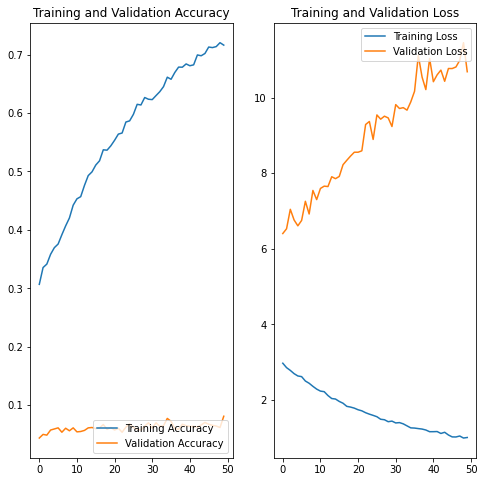

In [108]:
# visualize the new results after dropout
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [109]:
# this is to train the model
# can take some time

epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
202/202 [==============================] - 69s 343ms/step - loss: 0.9895 - accuracy: 0.7281 - val_loss: 11.7826 - val_accuracy: 0.0659
Epoch 2/50
202/202 [==============================] - 71s 351ms/step - loss: 0.9835 - accuracy: 0.7233 - val_loss: 11.2257 - val_accuracy: 0.0659
Epoch 3/50
202/202 [==============================] - 70s 347ms/step - loss: 0.9305 - accuracy: 0.7432 - val_loss: 11.3853 - val_accuracy: 0.0634
Epoch 4/50
202/202 [==============================] - 70s 348ms/step - loss: 0.9427 - accuracy: 0.7345 - val_loss: 11.7532 - val_accuracy: 0.0672
Epoch 5/50
202/202 [==============================] - 70s 347ms/step - loss: 0.9856 - accuracy: 0.7291 - val_loss: 11.2805 - val_accuracy: 0.0672
Epoch 6/50
202/202 [==============================] - 69s 342ms/step - loss: 0.9018 - accuracy: 0.7479 - val_loss: 11.3338 - val_accuracy: 0.0728
Epoch 7/50
202/202 [==============================] - 70s 348ms/step - loss: 0.8695 - accuracy: 0.7556 - val_loss: 12.2449 -

KeyboardInterrupt: 

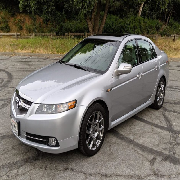

This image most likely belongs to Acura TL Type-S 2008 with a 67.05 percent confidence.


In [117]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "2008_acura_tl.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

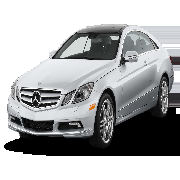

This image most likely belongs to Mercedes-Benz S-Class Sedan 2012 with a 78.77 percent confidence.


In [122]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "2012-mercedes-benz-e-class.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

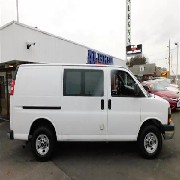

This image most likely belongs to Audi TT RS Coupe 2012 with a 66.87 percent confidence.


In [118]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "GMC-SavanaVan2012.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

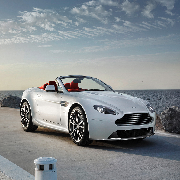

This image most likely belongs to Mercedes-Benz E-Class Sedan 2012 with a 96.80 percent confidence.


In [119]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "2012_AstonMartin_V8VantageRoadster1.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

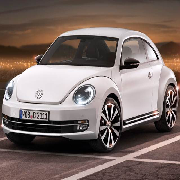

This image most likely belongs to Aston Martin V8 Vantage Convertible 2012 with a 91.62 percent confidence.


In [120]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "2012-Volkswagen-Beetle.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

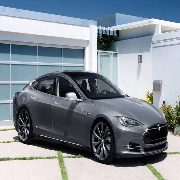

This image most likely belongs to Volkswagen Beetle Hatchback 2012 with a 43.88 percent confidence.


In [121]:
# now we try to predict new data

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    "2012_tesla_model-s_sedan.jpg", target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)